In [3]:
from keras.models import Model
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from os import listdir
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os.path import isfile, join
from keras.applications.vgg16 import VGG16
import pickle

In [4]:
!nvidia-smi

Tue Jan 22 10:15:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0  On |                  N/A |
|  0%   35C    P8    18W / 250W |   1099MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   33C    P8    16W / 250W |     11MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
DATA = "STATPRO"

In [4]:
train_path = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/train/images/"
validpath = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/test/images/"


In [5]:
model = VGG16(weights = "imagenet", include_top=False, input_shape = (256,256, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 11 layers.
for layer in model.layers[:11]:
    layer.trainable = False
    

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=["accuracy"])


/home1/tirthankar/miniconda2/envs/raghav_btp/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [6]:
print(model_final.summary())
for layer in  model_final.layers:
    print(layer.trainable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    shuffle=True,
    seed=42
)

valid_generator = test_datagen.flow_from_directory(
    directory=validpath,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 5123 images belonging to 2 classes.
Found 2545 images belonging to 2 classes.


In [11]:
# Save the model according to the conditions  
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

#nb_train_samples = 500
# Train the model 

checkpoint = ModelCheckpoint(DATA+'-img-model-best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

model_final.fit_generator(train_generator, verbose = 1,steps_per_epoch = 200, epochs = 3,callbacks = [checkpoint] , validation_data = valid_generator,validation_steps=32)
    

Epoch 1/3
200/200 [==============================] - 295s 1s/step - loss: 2.0086 - acc: 0.8754 - val_loss: 9.6092 - val_acc: 0.4038

Epoch 00001: val_loss improved from inf to 9.60924, saving model to ARTINT-img-model-best.h5
Epoch 2/3
200/200 [==============================] - 260s 1s/step - loss: 1.9275 - acc: 0.8804 - val_loss: 9.5337 - val_acc: 0.4085

Epoch 00002: val_loss improved from 9.60924 to 9.53370, saving model to ARTINT-img-model-best.h5
Epoch 3/3
  9/200 [>.............................] - ETA: 2:08 - loss: 1.9168 - acc: 0.8811

KeyboardInterrupt: 

# 

In [57]:
#model.load_weights('model-best.h5')

new_model = Model(inputs = model_final.inputs, outputs = model_final.layers[-2].output)

new_model.load_weights(DATA+'-img-model-best.h5', by_name = True)



In [58]:
def prep_dict(path,image_path,prefix,dict):
    for i in listdir(path):
        x = []
        for j in listdir(image_path):
            if i[:len(i)-4] in j:
                x.append(j)
        dict[prefix+i] = x
        


In [59]:
path = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/train/"
train_path = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/train/images/"
validpath = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/test/images/"
train_dict = {}
test_dict = {}
prep_dict(path+"positive_pdf/",train_path+"positive_img","pos_",train_dict)
prep_dict(path+"negative_pdf",train_path+"negative_img","neg_",train_dict)
path = "/home1/tirthankar/btpfinal/dataset/"+DATA+"/test/"
prep_dict(path+"positive_pdf/",validpath+"positive_img","pos_",test_dict)
prep_dict(path+"negative_pdf",validpath+"negative_img","neg_",test_dict)


In [60]:
len(train_dict)

3064

60


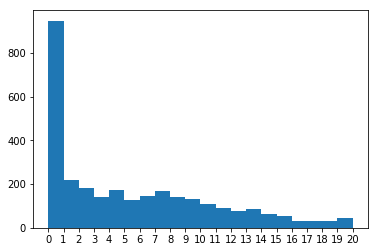

In [61]:
j = []
for i in train_dict.keys():
    j.append(len(train_dict[i]))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.hist(j, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
print(max(j))
    

In [62]:
img = listdir("/home1/tirthankar/btpfinal/dataset/"+DATA+"/train/images/positive_img")
filename = []
imagevector = []
c = 0
for i in img:
    c+=1
    if c%500 == 0:
        print(c)
    filename.append(i)
    image = load_img(train_path+"positive_img/"+i, target_size=(256, 256))
    image = img_to_array(image)
    image = image/255.0
    imagevector.append(image)
    
#imagevector.shape

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500


In [63]:
img = listdir("/home1/tirthankar/btpfinal/dataset/JNCA/"+DATA+"/images/negative_img")

c = 0
for i in img:
    c+=1
    if c%500 == 0:
        print(c)
    filename.append(i)
    image = load_img(train_path+"negative_img/"+i, target_size=(256, 256))
    image = img_to_array(image)
    image = image/255.0
    imagevector.append(image)
     
#imagevector.shape

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [64]:
img_array = np.array(imagevector)
pred =  new_model.predict(img_array)
pred.shape

(16853, 512)

In [ ]:
img = listdir("/home1/tirthankar/btpfinal/dataset/"+DATA+"/test/images/positive_img")
testfilename = []
testimagevector = []
c = 0
for i in img:
    c+=1
    if c%500 == 0:
        print(c)
    testfilename.append(i)
    image = load_img(validpath+"positive_img/"+i, target_size=(256, 256))
    image = img_to_array(image)
    image = image/255.0
    testimagevector.append(image)
    
img = listdir("/home1/tirthankar/btpfinal/dataset/"+DATA+"/test/images/negative_img")

c = 0
for i in img:
    c+=1
    if c%500 == 0:
        print(c)
    testfilename.append(i)
    image = load_img(validpath+"negative_img/"+i, target_size=(256, 256))
    image = img_to_array(image)
    image = image/255.0
    testimagevector.append(image)

In [68]:
c = 0
d = 0
for x in range(0,pred.shape[0]):
    for y in range(0, pred.shape[1]):
        d+=1
        if pred[x,y] != 0:
            c+=1

print(c)
print(d)

1112441
8628736


In [69]:
testimg_array = np.array(testimagevector)
testpred =  new_model.predict(testimg_array)
testpred.shape

(4231, 512)

In [71]:
c = 0
d = 0
for x in range(0,testpred.shape[0]):
    for y in range(0, testpred.shape[1]):
        d+=1
        if testpred[x,y] != 0:
            c+=1

print(c)
print(d)

278965
2166272


In [96]:
train_img_file = []
train_img_modal_vector = []
y = 0
for i in train_dict.keys():
    y+=1
    
    if y%500 ==0:
            print(y)
    train_img_file.append(i)
    temp = []
    c = 0
    for j in range(len(filename)):
        
        if i[4:len(i)-4] in filename[j]:
            temp.append(pred[j])
            c += 1
            if c==8:
                break
    while c != 8:
        temp.append(np.zeros((512)))
        c+=1
        
    temp =np.concatenate(temp)
    train_img_modal_vector.append(temp)
    
    

500
1000
1500
2000
2500
3000


In [97]:
print(train_img_modal_vector[0].shape)

(4096,)


In [98]:
test_img_file = []
test_img_modal_vector = []
y = 0
for i in test_dict.keys():
    y+=1
    
    if y%500 ==0:
            print(y)
    test_img_file.append(i)
    temp = []
    c = 0
    for j in range(len(testfilename)):
        
        if i[4:len(i)-4] in testfilename[j]:
            temp.append(testpred[j])
            c += 1
            if c==8:
                break
    while c != 8:
        temp.append(np.zeros((512)))
        c+=1
        
    temp = np.concatenate(temp)
    test_img_modal_vector.append(temp)
    


500


In [99]:
train_img_modal_vector = np.array(train_img_modal_vector)
test_img_modal_vector = np.array(test_img_modal_vector)

In [100]:
for i in range(len(train_img_modal_vector)):
    print(train_img_modal_vector[i].shape)

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


In [101]:
print(len(train_img_file))
print(len(test_img_file))
print(train_img_modal_vector.shape)
print(test_img_modal_vector.shape)

3064
769
(3064, 4096)
(769, 4096)


In [102]:
np.save(DATA+"_train_img_modal_vector",train_img_modal_vector)
np.save(DATA+"JNCA_test_img_modal_vector",test_img_modal_vector)

In [103]:

pickle.dump(train_img_file, open(DATA+"_train_img_filename_for_img_modal_vector.p", "wb"))  # save it into a file named save.p

pickle.dump(test_img_file, open(DATA+"_test_img_filename_for_img_modal_vector.p", "wb"))  # save it into a file named save.p
